In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl.workbook import Workbook
import numpy as np

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from itertools import product
import os

In [13]:
categories = ['animal', 'fruit', 'vegetable', 'vehicle', 'clothing', 'sport', 'instrument', 'profession']
languages = ['American English', 'French', 'Portuguese', 'German', 'Spanish']
langs = ['English', 'French', 'Portuguese', 'German', 'Spanish']

In [75]:
all_df_translated = {}  # category: {lang: data}

for category in categories:
    temp = {}
    for language in languages:
        temp[language] = pd.read_excel('output.xlsx', sheet_name=f'{category}_{language}', usecols=['rating_average', 'english', 'human_data'])
        temp[language]['english'] = temp[language]['english'].str.lower() 

        if language == "Spanish":
            temp[language]['human_data'] = (temp[language]['human_data']/284).round(2) #284 total participants
        elif language == "Portuguese":
            temp[language]['human_data'] = (temp[language]['human_data']/100).round(2) #100 participants

        temp[language]['rating_average'] /= 10.0
    all_df_translated[category] = temp

In [81]:
# Common Exemplars
common_exemplars = {}

for category in categories:
    # Step 1: Find common exemplars across all languages
    common_values = set(all_df_translated[category][next(iter(all_df_translated[category]))]["english"])
    for df in all_df_translated[category].values():
        common_values &= set(df["english"])

    if not common_values:
        print(f"No common exemplars found for category: {category}")
        continue

    # Step 2: Filter data for common exemplars and store
    filtered_dfs = {
        language: df[df["english"].isin(common_values)]
                    .sort_values("english")
                    .drop_duplicates("english", keep="first")
        for language, df in all_df_translated[category].items()
    }
    common_exemplars[category] = filtered_dfs


In [35]:
# Add exemplars as 0 if not present
for category in categories:
    # Initialize a set to store all unique exemplars in the category
    exemplars = set()
    for language_df in all_df_translated[category].values():
        exemplars.update(language_df['english'])

    # Add missing exemplars to each language dataset
    for language, df in all_df_translated[category].items():
        # Find missing exemplars in this language dataset
        missing_exemplars = exemplars - set(df['english'])
        
        # Create a DataFrame with the missing exemplars, filling other columns with 0
        missing_data = pd.DataFrame({
            'english': list(missing_exemplars),
            'rating_average': 0,  # Assuming 0 for missing Rating values
            'human_data': 0       # Assuming 0 for missing Human Data values
        })

        # Append the missing data to the language dataset and sort by 'english'
        all_df_translated[category][language] = (
            pd.concat([df, missing_data], ignore_index=True)
            .sort_values(by='english', ascending=True)
            .reset_index(drop=True)
        )

In [82]:
output_file = "common_output.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    for category, lang_data in common_exemplars.items():
        for language, df in lang_data.items():
            df = df.sort_values('english')
            # Write each category-language combination to a separate sheet
            sheet_name = f"{category}_{language}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Processed data has been saved to {output_file}.")

Processed data has been saved to common_output.xlsx.


In [25]:
# Add rank columns
with pd.ExcelWriter('common_output.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    for category in categories:
        for language in languages:
            sheet_name = f'{category}_{language}'
            current = pd.read_excel('common_output.xlsx', sheet_name=sheet_name)
            
            # Ensure sorting for unique ranking: 'rating_average'
            current = current.sort_values(by=['rating_average', 'english'], ascending=[False, True])
            current['rating_average_rank'] = range(1, len(current) + 1)

            # Ensure sorting for unique ranking: 'human_data'
            current = current.sort_values(by=['human_data', 'english'], ascending=[False, True])
            current['human_data_rank'] = range(1, len(current) + 1)

            # Save the updated DataFrame back to the same file
            current = current.sort_values(by=['english'], ascending=True)
            current.to_excel(writer, sheet_name=sheet_name, index=False)


In [26]:
final_df = {}  # category: {lang: data}

for category in categories:
    temp = {}
    for language in languages:
        temp[language] = pd.read_excel('common_output.xlsx', sheet_name=f'{category}_{language}')
    final_df[category] = temp

In [82]:
def make_heatmap(final_df, languages, categories, output_dir, col_a, col_b, correlation_type):
    os.makedirs(output_dir, exist_ok=True)

    # Prepare storage for averaged Fisher z-scores
    z_scores_sum = np.zeros((len(languages), len(languages)))  # Sum of Fisher z-scores

    for category in categories:
        correlations = []        
        # Compute pairwise correlations
        for lang1 in languages:
            for lang2 in languages:
                if lang1 == lang2 and col_a == col_b:
                    correlation = 1.0
                    z_score = 45
                else:
                    df1 = final_df[category][lang1]
                    df2 = final_df[category][lang2]

                    # Rename columns in df1 and df2 to avoid conflicts
                    df1 = df1.rename(columns={col_a: f'{col_a}_{lang1}'})
                    df2 = df2.rename(columns={col_b: f'{col_b}_{lang2}'})

                    # Align the datasets by the 'english' column
                    merged = pd.merge(df1[['english', f'{col_a}_{lang1}']], df2[['english', f'{col_b}_{lang2}']], on='english')
                    
                    # Compute Spearman correlation
                    if correlation_type == 'rank':   # spearman
                        correlation, _ = spearmanr(merged[f'{col_a}_{lang1}'], merged[f'{col_b}_{lang2}'])
                    else:  # continuous: pearson
                        correlation, _ = pearsonr(merged[f'{col_a}_{lang1}'], merged[f'{col_b}_{lang2}'])
                
                    z_score = np.arctanh(correlation)  # Fisher's z-transform

                i, j = languages.index(lang1), languages.index(lang2)
                # Update z-scores and counts
                z_scores_sum[i, j] += z_score

                correlations.append({'Language 1': lang1, 'Language 2': lang2, 'Correlation': correlation})
        correlation_df = pd.DataFrame(correlations)
        # Sort pairs and drop duplicates
        full_df = correlation_df.drop_duplicates(subset=['Language 1', 'Language 2'])

        pivot_table = full_df.pivot(index='Language 1', columns='Language 2', values='Correlation')
        # Save the heatmap for the category
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_table, annot=True, cmap="coolwarm", cbar=True, vmin=0, vmax=1)

        # Special for GPT vs Human
        if col_a != and col_b:
            # Add overall axis labels
            plt.xlabel("Human Ratings")
            plt.ylabel("GPT Ratings")

        plt.savefig(f"{output_dir}/{category}.png")
        plt.close()

    # Compute the average z-scores and convert back to correlations
    average_z_scores = np.divide(z_scores_sum, len(categories))
    average_correlations = np.tanh(average_z_scores)  # Convert back to correlation
    print(average_correlations)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(average_correlations, index=langs, columns=langs), annot=True, cmap="coolwarm", cbar=True, vmin=0, vmax=1)
    
    # Special for GPT vs Human
    if col_a != col_b:
        # Add overall axis labels
        plt.xlabel("Human Ratings")
        plt.ylabel("GPT Ratings")
    
    plt.savefig(f"{output_dir}/average.png")
    plt.close()

SyntaxError: invalid syntax (1635261291.py, line 49)

In [29]:
# Using continuous variables: Pearson correaltion
make_heatmap(final_df, languages, categories, 'HumanVsHuman_Pearson', 'human_data', 'human_data', 'score')
make_heatmap(final_df, languages, categories, 'GPTVsGPT_Pearson', 'rating_average', 'rating_average', 'score')
make_heatmap(final_df, languages, categories, 'GPTVsHuman_Pearson', 'rating_average', 'human_data', 'score')

[[1.         0.80485152 0.5283575  0.41613678 0.66740989]
 [0.80485152 1.         0.54415409 0.45309419 0.66220322]
 [0.5283575  0.54415409 1.         0.26702807 0.40429307]
 [0.41613678 0.45309419 0.26702807 1.         0.29969071]
 [0.66740989 0.66220322 0.40429307 0.29969071 1.        ]]
[[1.         0.66279309 0.64955727 0.72959546 0.78865873]
 [0.66279309 1.         0.43039008 0.58122729 0.77129582]
 [0.64955727 0.43039008 1.         0.25339498 0.5865446 ]
 [0.72959546 0.58122729 0.25339498 1.         0.54975498]
 [0.78865873 0.77129582 0.5865446  0.54975498 1.        ]]
[[0.68829703 0.54242273 0.50508345 0.1732704  0.46083068]
 [0.4749249  0.58783637 0.4232226  0.20900749 0.29113264]
 [0.45101581 0.38242548 0.3330643  0.14770641 0.36916679]
 [0.55399928 0.53261419 0.40925475 0.54227644 0.36648718]
 [0.60891293 0.66779534 0.49931439 0.15395055 0.48241565]]


In [83]:
# Using rank: Spearman correlation
make_heatmap(final_df, languages, categories, 'HumanVsHuman_Spearman', 'human_data_rank', 'human_data_rank', 'rank')
make_heatmap(final_df, languages, categories, 'GPTVsGPT_Spearman', 'rating_average_rank', 'rating_average_rank', 'rank')
make_heatmap(final_df, languages, categories, 'GPTVsHuman_Spearman', 'rating_average_rank', 'human_data_rank', 'rank')

[[1.         0.71137076 0.44280501 0.52681993 0.63477958]
 [0.71137076 1.         0.51751945 0.47712956 0.56653025]
 [0.44280501 0.51751945 1.         0.24604289 0.47615617]
 [0.52681993 0.47712956 0.24604289 1.         0.26030998]
 [0.63477958 0.56653025 0.47615617 0.26030998 1.        ]]
[[1.         0.72763156 0.57116435 0.77145595 0.77620948]
 [0.72763156 1.         0.46847235 0.70051511 0.76145096]
 [0.57116435 0.46847235 1.         0.32629069 0.47076337]
 [0.77145595 0.70051511 0.32629069 1.         0.62204411]
 [0.77620948 0.76145096 0.47076337 0.62204411 1.        ]]
[[0.69260539 0.53159489 0.4203466  0.1940021  0.51575569]
 [0.60836208 0.73682362 0.43392679 0.23809734 0.44959922]
 [0.38287288 0.22644361 0.16835864 0.16387468 0.33969852]
 [0.58999351 0.55403848 0.35662322 0.46070293 0.36058586]
 [0.62059774 0.71439021 0.47498768 0.34872335 0.44196955]]


In [24]:
# For figure 1 and 2 -- (use the unique upper half of heatmap) z score transformation, then Pearson's correlation
# (HvH and GvG)
# This uses the Pearson continuous correaltion
HvH = [0.80485152, 0.5283575,  0.41613678, 0.66740989,
       0.54415409, 0.45309419, 0.66220322,
       0.26702807, 0.40429307, 0.29969071]

GvG = [0.66279309, 0.64955727, 0.72959546, 0.78865873,
       0.43039008, 0.58122729, 0.77129582,
       0.25339498, 0.5865446, 0.54975498]

def transform(l):
    r = []
    for c in l:
        r.append(np.arctanh(c))
    return r

HvH = transform(HvH)
GvG = transform(GvG)

print(pearsonr(HvH, GvG))

PearsonRResult(statistic=0.5706368233722002, pvalue=0.08494373186739139)


In [32]:
# This uses the Spearman rank correaltion (note: the ranks gave HvH and GvG)
# user pearson to get the correlation between them
HvH = [0.71137076, 0.44280501, 0.52681993, 0.63477958,
        0.51751945, 0.47712956, 0.56653025,
        0.24604289, 0.47615617, 0.26030998]
GvG = [0.72763156, 0.57116435, 0.77145595, 0.77620948,
        0.46847235, 0.70051511, 0.76145096,
        0.32629069, 0.47076337, 0.62204411]

HvH = transform(HvH)
GvG = transform(GvG)

print(pearsonr(HvH, GvG))

PearsonRResult(statistic=0.6497562514259047, pvalue=0.04200128391564881)


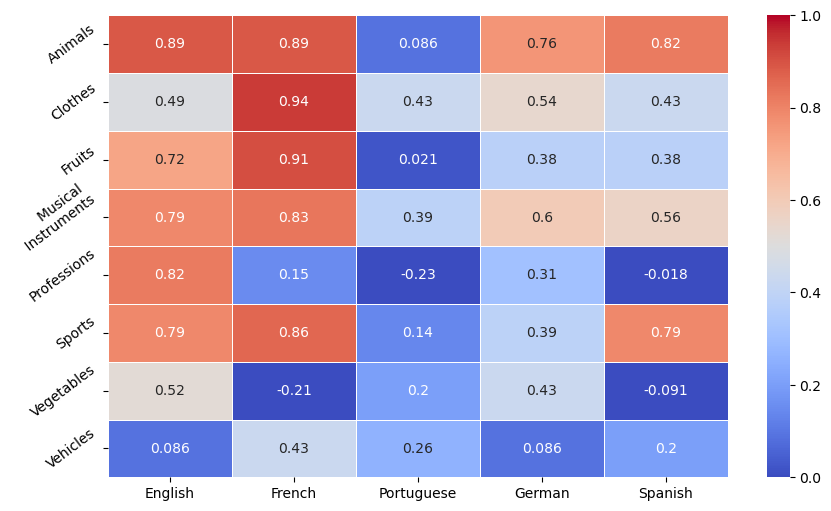

In [46]:
# Diagonals of GPT vs Human heatmap
data = {
    "Categories": ["Animals", "Clothes", "Fruits", "Musical \n Instruments", "Professions", "Sports", "Vegetables", "Vehicles"],
    "English": [0.89, 0.49, 0.72, 0.79, 0.82, 0.79, 0.52, 0.086],
    "French": [0.89, 0.94, 0.91, 0.83, 0.15, 0.86, -0.21, 0.43],
    "Portuguese": [0.086, 0.43, 0.021, 0.39, -0.23, 0.14, 0.2, 0.26],
    "German": [0.76, 0.54, 0.38, 0.6, 0.31, 0.39, 0.43, 0.086],
    "Spanish": [0.82, 0.43, 0.38, 0.56, -0.018, 0.79, -0.091, 0.2],
}

# Create DataFrame
df = pd.DataFrame(data)

# Set Categories as index
df.set_index("Categories", inplace=True)

# Create Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    df, 
    annot=True,  # Show values in the heatmap
    cmap="coolwarm",  # Blue to red colormap
    vmin=0, vmax=1,  # Set range of color scale
    linewidths=0.5,  # Add gridlines
)
plt.ylabel("")
plt.yticks(rotation=37)

# Add title
plt.savefig("GvH_Diagonals")


In [76]:
# using the average heatmap (diagonals, coarse values)
GPTvHuman = [0.69, 0.74, 0.17, 0.46, 0.44]

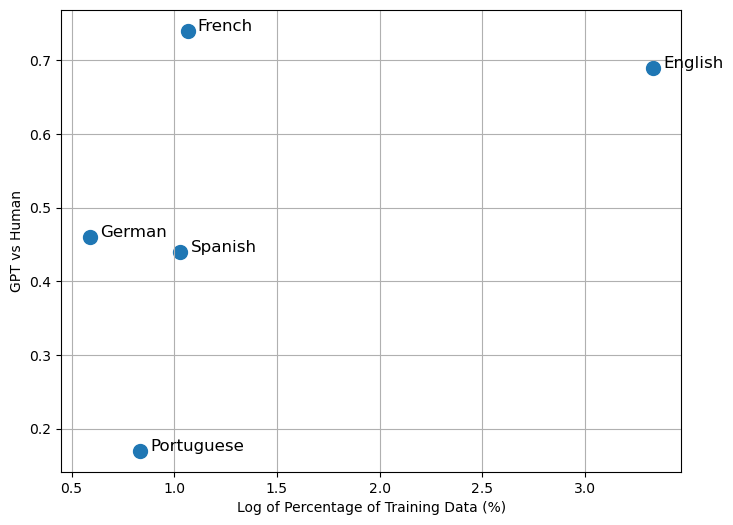

In [77]:
langs = ['English', 'French', 'Portuguese', 'German', 'Spanish']
# Citation: 
percentage_training_data = [28, 2.9, 2.3, 1.8, 2.8]
percentage_training_data = [np.log(data) for data in percentage_training_data]

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(percentage_training_data, GPTvHuman, s=100)

# Add labels for each point
for i, lang in enumerate(langs):
    plt.text(percentage_training_data[i] + 0.05, GPTvHuman[i], lang, fontsize=12)

# Set labels and title
plt.xlabel('Log of Percentage of Training Data (%)')
plt.ylabel('GPT vs Human')

# Display plot
plt.grid(True)
plt.show()

In [86]:
GvH = [[0.69260539, 0.53159489, 0.4203466,  0.1940021,  0.51575569],
 [0.60836208, 0.73682362, 0.43392679, 0.23809734, 0.44959922],
 [0.38287288, 0.22644361, 0.16835864, 0.16387468, 0.33969852],
 [0.58999351, 0.55403848, 0.35662322, 0.46070293, 0.36058586],
 [0.62059774, 0.71439021, 0.47498768, 0.34872335, 0.44196955]]

GPTvHuman = []
for j in range(len(GvH[0])):
    tot_z = 0
    count = 0
    for i in range(len(GvH)):
        corr = GvH[i][j]
        z_score = np.arctanh(corr)
        tot_z += z_score
        count += 1
    av_z = tot_z / count
    av_corr = np.tanh(av_z)
    GPTvHuman.append(av_corr)

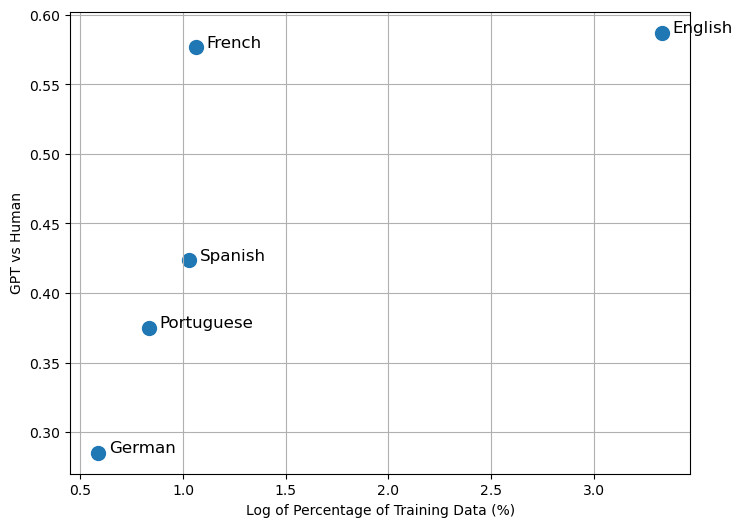

In [88]:
# Citation: 
percentage_training_data = [28, 2.9, 2.3, 1.8, 2.8]
percentage_training_data = [np.log(data) for data in percentage_training_data]

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(percentage_training_data, GPTvHuman, s=100)

# Add labels for each point
for i, lang in enumerate(langs):
    plt.text(percentage_training_data[i] + 0.05, GPTvHuman[i], lang, fontsize=12)

# Set labels and title
plt.xlabel('Log of Percentage of Training Data (%)')
plt.ylabel('GPT vs Human')

# Display plot
plt.grid(True)
plt.savefig('GvH_vs_training_data.png')
plt.show()

In [84]:
GvH = [[0.69260539, 0.53159489, 0.4203466,  0.1940021,  0.51575569],
 [0.60836208, 0.73682362, 0.43392679, 0.23809734, 0.44959922],
 [0.38287288, 0.22644361, 0.16835864, 0.16387468, 0.33969852],
 [0.58999351, 0.55403848, 0.35662322, 0.46070293, 0.36058586],
 [0.62059774, 0.71439021, 0.47498768, 0.34872335, 0.44196955]]

GPTvHuman = []

for i in range(len(GvH)):
    tot_z = 0
    count = 0
    for j in range(len(GvH[0])):
        corr = GvH[i][j]
        z_score = np.arctanh(corr)
        tot_z += z_score
        count += 1
    av_z = tot_z / count
    av_corr = np.tanh(av_z)
    GPTvHuman.append(av_corr)

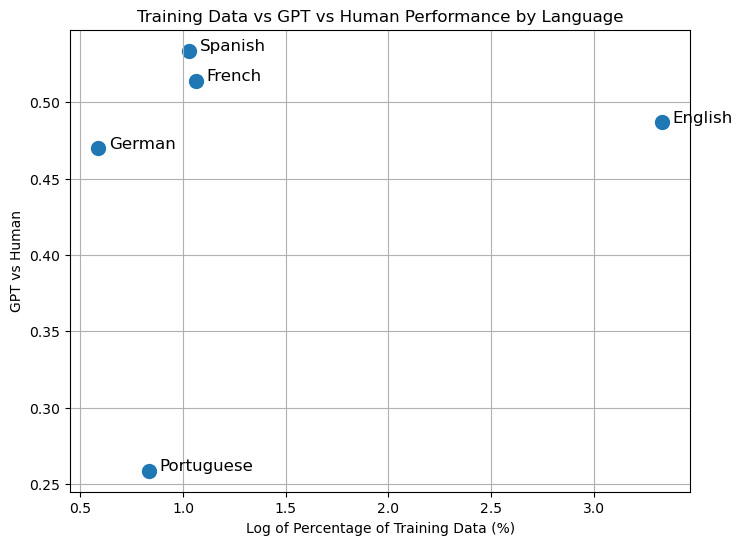

In [85]:
langs = ['English', 'French', 'Portuguese', 'German', 'Spanish']
# Citation: 
percentage_training_data = [28, 2.9, 2.3, 1.8, 2.8]
percentage_training_data = [np.log(data) for data in percentage_training_data]

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(percentage_training_data, GPTvHuman, s=100)

# Add labels for each point
for i, lang in enumerate(langs):
    plt.text(percentage_training_data[i] + 0.05, GPTvHuman[i], lang, fontsize=12)

# Set labels and title
plt.xlabel('Log of Percentage of Training Data (%)')
plt.ylabel('GPT vs Human')
plt.title('Training Data vs GPT vs Human Performance by Language')

# Display plot
plt.grid(True)
plt.show()